# 1. Keras로 MNIST 모델생성
생성된 모델이 있으면 Skip

In [27]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam 
from keras.utils import np_utils

# MNIST 데이터 읽어 들이기 --- (※1)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 데이터를 float32 자료형으로 변환하고 정규화하기 --- (※2)
X_train = X_train.reshape(60000, 784).astype('float32')
X_test  = X_test.reshape(10000, 784).astype('float')
X_train /= 255
X_test  /= 255

# 레이블 데이터를 0-9까지의 카테고리를 나타내는 배열로 변환하기 --- (※2a)
y_train = np_utils.to_categorical(y_train, 10)
y_test  = np_utils.to_categorical(y_test, 10)

# 모델 구조 정의하기 --- (※3)
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

# 모델 구축하기 --- (※4)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# 데이터 훈련하기 --- (※5)
hist = model.fit(X_train, y_train, epochs = 100)

# 테스트 데이터로 평가하기 --- (※6)
score = model.evaluate(X_test, y_test, verbose=1)
print('loss=', score[0])
print('accuracy=', score[1])

# 모델 저장하기 --- (※6)
model.save('model/keras_mnist.h5')  # creates a HDF5 file 'my_model.h5'
print("keras_mnist Image Classification Model Save OK")

Epoch 1/100
1875/1875 [==============================] - 22s 5ms/step - loss: 0.3555 - accuracy: 0.8886
Epoch 2/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1080 - accuracy: 0.9678
Epoch 3/100
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0797 - accuracy: 0.9746
Epoch 4/100
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0608 - accuracy: 0.9812
Epoch 5/100
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0562 - accuracy: 0.9821
Epoch 6/100
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0462 - accuracy: 0.9852
Epoch 7/100
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0417 - accuracy: 0.9869 0s - loss: 0.0416 - accura
Epoch 8/100
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0385 - accuracy: 0.9878
Epoch 9/100
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0389 - accuracy: 0.9880
Epoch 10/100
1875/1875 [============

# 2. 필기인식 Data Load


손글씨 숫자 데이터로 [MNIST](http://yann.lecun.com/exdb/mnist/) 에서 공개하고 있는 데이를 사용.
이미지 데이터는 각 픽셀을 Grayscale 256단계로 나타내며, 왼쪽 위부터 오른쪽 아래로 차례차례 픽셀이 나열된 형태.
0은 기본 배경색(흰색)이고, 1 ~ 255가 실제 손글씨가 적힌 부분을 나타냄 (28 X 28 픽셀)

In [28]:
import numpy as np
import os
import urllib.request
import gzip
import struct
import base64

def download_data(url, force_download=True): 
    fname = url.split("/")[-1]
    if force_download or not os.path.exists(fname):
        urllib.request.urlretrieve(url, fname)
    return fname

def read_data(label_url, image_url):
    with gzip.open(download_data(label_url)) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.frombuffer(flbl.read(), dtype=np.int8)
    with gzip.open(download_data(image_url), 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.frombuffer(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

path='http://yann.lecun.com/exdb/mnist/'

(train_lbl, train_img) = read_data(path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
(val_lbl, val_img) = read_data(path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')

처음 10 개의 이미지를 레이블(Lable)과 함께 출력함

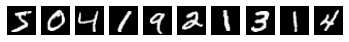

Label: [5 0 4 1 9 2 1 3 1 4]


In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_img[i], cmap='Greys_r')
    plt.axis('off')
plt.show()
print('Label: %s' % (train_lbl[0:10],))

# 3. 모델 불러오기

In [30]:
import numpy as np
from keras.models import load_model

model = load_model('model/keras_mnist.h5')

모델 테스트

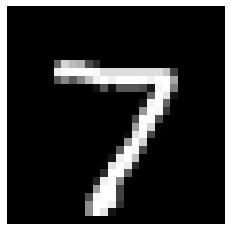

Classified as 7 with probability 1.000000


In [32]:
img = val_img[0]

plt.imshow(img, cmap='Greys_r')
plt.axis('off')
plt.show()
re_val_img = img.reshape(1, 784).astype('float32')

prob = model.predict(re_val_img/255)[0]
#prob = model.predict(val_img[0:1].astype(np.float32)/255)[0]

assert max(prob) > 0.99, "Low prediction accuracy."
print ('Classified as %d with probability %f' % (prob.argmax(), max(prob)))

# 4. Input Form 그리기

In [33]:
input_form = """
<style type="text/css">
  canvas { border: 1px solid black; }
</style>

<div id="board">

  <canvas id="myCanvas" width="200px" height="200px">
    Sorry, your browser doesn't support canvas technology.
  </canvas>

  <p>
    <button id="classify" onclick="classify()">
      Classify
    </button>

    <button id="clear" onclick="myClear()">
      Clear
    </button>
    Result: 
    <input type="text" id="result_output" size="5" value="">
  </p>

</div>
"""

# 5. Script 작성

In [73]:
javascript = """
<script type = "text/JavaScript" src = "https://ajax.googleapis.com/ajax/libs/jquery/1.4.2/jquery.min.js?ver=1.4.2" > </script>

<script type = "text/javascript" >
    function init() {
        var myCanvas = document.getElementById("myCanvas");
        var curColor = $('#selectColor option:selected').val();
        if (myCanvas) {
            var isDown = false;
            var ctx = myCanvas.getContext("2d");
            var canvasX, canvasY;
            ctx.lineWidth = 8;
            $(myCanvas).mousedown(function(e) {
                isDown = true;
                ctx.beginPath();
                var parentOffset = $(this).parent().offset();
                canvasX = e.pageX - parentOffset.left;
                canvasY = e.pageY - parentOffset.top;
                ctx.moveTo(canvasX, canvasY);
            }).mousemove(function(e) {
                if (isDown != false) {
                    var parentOffset = $(this).parent().offset();
                    canvasX = e.pageX - parentOffset.left;
                    canvasY = e.pageY - parentOffset.top;
                    ctx.lineTo(canvasX, canvasY);
                    ctx.strokeStyle = curColor;
                    ctx.stroke();
                }
            }).mouseup(function(e) {
                isDown = false;
                ctx.closePath();
            });
        }
        $('#selectColor').change(function() {
            curColor = $('#selectColor option:selected').val();
        });
    }

init();

function handle_output(out) {
    console.log(out);
    var res = null;
    // if output is a print statement
    if(out.msg_type == "stream"){
       res = out.content.data;
    }
    // if output is a python object
    else if(out.msg_type === "execute_result"){
       res = out.content.data["text/plain"];
    }
    // if output is a python error
    else if(out.msg_type == "pyerr"){
       res = out.content.ename + ": " + out.content.evalue;
    }
    // if output is something we haven't thought of
    else{
       res = out.msg_type;  
    }
    document.getElementById("result_output").value = res;
}

function classify() {
    var kernel = IPython.notebook.kernel;
    var myCanvas = document.getElementById("myCanvas");
    data = myCanvas.toDataURL('image/png');
    document.getElementById("result_output").value = "";
    kernel.execute("classifyML('" + data + "')", {
        'iopub': {
            'output': handle_output
        }
    }, {
        silent: false
    });
}

function myClear() {
    var myCanvas = document.getElementById("myCanvas");
    myCanvas.getContext("2d").clearRect(0, 0, myCanvas.width, myCanvas.height);
}
</script>
"""

# ※ 테스트 ※

In [74]:
from IPython.display import HTML
import cv2
import numpy as np

def classifyML(img):
    print('ddd')
    img = base64.b64decode(img[len('data:image/png;base64,'):])
    img = cv2.imdecode(np.fromstring(img, np.uint8), -1)
    img = cv2.resize(img[:,:,3], (28,28))
    img = img.astype(np.float32).reshape((1,784))/255.0
    print(model.predict(img)[0].argmax())
    return model.predict(img)[0].argmax()

HTML(input_form + javascript)